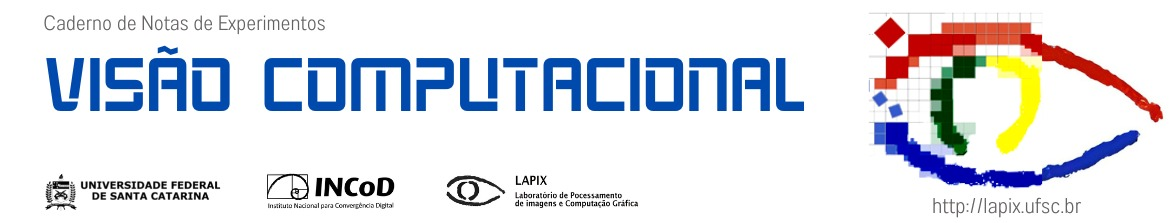

# 15.3.1.Segmentação Semântica Com SAM2
#### Março de 2025

### Autores:

* Aldo von Wangenheim: aldo.vw@ufsc.br [Review, Maintainer]
* Luis Otavio Santos: luis.otavio.santos@posgrad.ufsc.br

In [ ]:
!nvidia-smi

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
!nvcc --version

try:
    import google.colab
    _ON_COLAB = True
except:
    _ON_COLAB = False

print('Running on Google Colab = ', _ON_COLAB)
import os
import torch
from IPython import get_ipython
import os
# Definir o caminho base
if _ON_COLAB:
    BASE_PATH = "/content"
    import locale
    locale.getpreferredencoding = lambda: "UTF-8"
else:
    BASE_PATH = "/lapix" # trocar para o base path do seu computador se estiver rodando localmente, deixar /lapix se estiver rodando nos conteiners lapix
    VISIBLE_GPUS = [1] # Selecionar a GPU PARA RODAR! VER QUAL ESTA LIVRE

    if torch.cuda.device_count() != 8:
        print("GPU SETADA - PULANDO ETAPA")
    else:
        os.environ["CUDA_VISIBLE_DEVICES"] = str(VISIBLE_GPUS).replace("]", "").replace("[","").replace(" ", "")
        os.environ["NVIDIA_VISIBLE_DEVICES"] = str(VISIBLE_GPUS).replace("]", "").replace("[","").replace(" ", "")
        print("CUDA GPUS NUMBER: ", torch.cuda.device_count())
    
os.chdir(BASE_PATH) # garantir que está executando no caminho base definido

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Mar_28_02:18:24_PDT_2024
Cuda compilation tools, release 12.4, V12.4.131
Build cuda_12.4.r12.4/compiler.34097967_0
Running on Google Colab =  False
CUDA GPUS NUMBER:  1


### Instalar SAM2

In [2]:
try:
    import sam2
except:
    !pip install git+https://github.com/facebookresearch/sam2.git

DEPRECATION: Loading egg at /root/anaconda3/envs/lapixdl/lib/python3.11/site-packages/paddleseg-0.0.0.dev0-py3.11.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /root/anaconda3/envs/lapixdl/lib/python3.11/site-packages/opencv_python-4.5.5.64-py3.11-linux-x86_64.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
  Cloning https://github.com/facebookresearch/sam2.git to /tmp/pip-req-build-qsf4eczt
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/sam2.git /tmp/pip-req-build-qsf4eczt
  Resolved https://github.com/facebookresearch/sam2.git to commit 2b90b9f5ceec907a1c18123530e92e794ad901a4
  Installing build dependencies ... done
  Get

### Download Dataset

In [4]:
import os
if os.path.isdir('/lapix/RTK'):
    print('Dataset já foi baixado')
else:
    # Download do dataset RTK pelo Mendeley
    file_link = "https://data.mendeley.com/public-files/datasets/hssswvmjwf/files/2c72e75d-1f50-457a-86f0-a5e3a4174df9/file_downloaded"
    !wget $file_link
    
    os.rename(os.path.join(BASE_PATH, "file_downloaded"), os.path.join(BASE_PATH, "file_downloaded.zip"))
    !unzip -qq -u file_downloaded.zip
    !rm file_downloaded.zip

Dataset já foi baixado


### Definir Dataset/Dataloader

In [3]:
import torch
import numpy as np
import cv2
import os
from torch.utils.data import Dataset, DataLoader
import albumentations as A
import matplotlib.pyplot as plt

class RTKDatasetSAM2(Dataset):
    def __init__(self, file_list, img_dir, label_dir, transform=None, img_size=(512, 512), max_objects=10):
        self.file_list = file_list
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.img_size = img_size
        self.transform = transform
        self.max_objects = max_objects

    def __len__(self):
        return len(self.file_list)
        
    def __getitem__(self, idx):
        img_name = self.file_list[idx]
        img_path = os.path.join(self.img_dir, img_name)
        label_path = os.path.join(self.label_dir, os.path.basename(img_name)) # máscara com mesmo nome da imagem

        image = cv2.imread(img_path)[..., ::-1]
        image = cv2.resize(image, self.img_size)

        mask = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, self.img_size, interpolation=cv2.INTER_NEAREST)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image, mask = augmented["image"], augmented["mask"]

        mat_map = mask
        inds = np.unique(mat_map)
        inds = inds[inds != 0]

        masks = np.zeros((self.max_objects, self.img_size[0], self.img_size[1]), dtype=np.uint8)
        points = np.zeros((self.max_objects, 1, 2), dtype=np.int32)
        labels = np.zeros((self.max_objects, 1), dtype=np.int32)
        num_objs = 0

        for ind in inds:
            if num_objs >= self.max_objects:
                break
            bin_mask = (mat_map == ind).astype(np.uint8)
            n_labels, cc_labels = cv2.connectedComponents(bin_mask)
            for obj_idx in range(1, n_labels):
                if num_objs >= self.max_objects:
                    break
                obj_mask = (cc_labels == obj_idx).astype(np.uint8)
                if obj_mask.sum() == 0:
                    continue
                masks[num_objs] = obj_mask
                coords = np.argwhere(obj_mask)
                yx = coords[np.random.randint(len(coords))]
                points[num_objs] = [[yx[1], yx[0]]]
                labels[num_objs] = [ind]
                num_objs += 1

        image = torch.from_numpy(image).permute(2, 0, 1).float() / 255.  # [C,H,W]
        masks = torch.from_numpy(masks)
        points = torch.from_numpy(points)
        labels = torch.from_numpy(labels)

        return image, masks, points, labels, num_objs

def sam2_collate_fn(batch):
    images, masks, points, labels, num_objs = zip(*batch)
    return (
        torch.stack(images),   # [B, C, H, W]
        torch.stack(masks),    # [B, max_objects, H, W]
        torch.stack(points),   # [B, max_objects, 1, 2]
        torch.stack(labels),   # [B, max_objects, 1]
        torch.tensor(num_objs) # [B]
    )


def read_paths(file):
    with open(file, 'r') as f:
        paths = [line.strip().replace('image/', '') for line in f.readlines()]
    return paths


# def sam2_collate_fn(batch):
#     images, masks, points, labels = zip(*batch)
#     images = np.stack(images)
#     return images, masks, points, labels


def create_dataloader(
    file_list,
    img_dir,
    label_dir,
    transform=None,
    batch_size=16,
    shuffle=True,
    num_workers=4,
    img_size=(224, 224)
):
    dataset = RTKDatasetSAM2(
        file_list,
        img_dir,
        label_dir,
        transform=transform,
        img_size=img_size
    )
    return DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle,
        pin_memory=True,
        drop_last=True,
        collate_fn=sam2_collate_fn
    )


/root/anaconda3/envs/lapixdl/lib/python3.11/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [4]:
img_dir = os.path.join(BASE_PATH, 'RTK/image')
label_dir = os.path.join(BASE_PATH,'RTK/label')

train_paths = read_paths(os.path.join(BASE_PATH,'RTK/trainpaths.txt'))
val_paths = read_paths(os.path.join(BASE_PATH,'RTK/valpaths.txt'))

BATCH_SIZE = 32


train_transforms = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5)
])

train_loader = create_dataloader(
    train_paths, img_dir, label_dir,
    transform=train_transforms,
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_loader = create_dataloader(
    val_paths, img_dir, label_dir,
    transform=None,
    batch_size=BATCH_SIZE,
    shuffle=False
)

print(f'Train samples: {len(train_loader.dataset)}')
print(f'Validation samples: {len(val_loader.dataset)}')

Train samples: 561
Validation samples: 140


### Testar Dataloader


Quantidade Total de imagens: 561

Batch Size: 4
Quantidade de iterações por época: 561 / 4 = 141.0
Quantidade total de iterações para 10 épocas: 10 * 141.0 = 1410



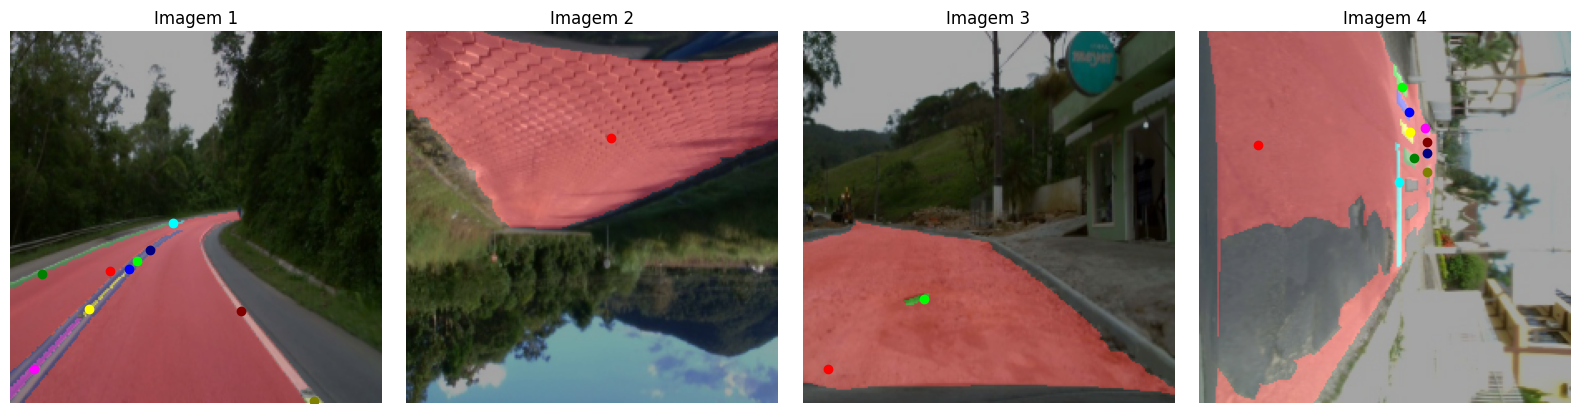

In [5]:
def preview_rtk_sam2_dataset(
    file_list,
    img_dir,
    label_dir,
    transform=None,
    batch_size=4,
    img_size=(224, 224),
    num_epoch=1,
    max_batches=1,
    class_colors=None,
    alpha=0.35
):
    dataset = RTKDatasetSAM2(file_list, img_dir, label_dir, transform=transform, img_size=img_size)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=sam2_collate_fn)

    if class_colors is None:
        class_colors = [
            (255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0),
            (255, 0, 255), (0, 255, 255), (128, 0, 0), (0, 128, 0),
            (0, 0, 128), (128, 128, 0), (128, 0, 128), (0, 128, 128)
        ]

    nr_img = len(dataset)
    iter_per_epoch = np.ceil(nr_img / batch_size)
    max_iter = int(iter_per_epoch * num_epoch)

    print(f"\nQuantidade Total de imagens: {nr_img}")
    print(f"\nBatch Size: {batch_size}")
    print(f"Quantidade de iterações por época: {nr_img} / {batch_size} = {iter_per_epoch}")
    print(f"Quantidade total de iterações para {num_epoch} épocas: {num_epoch} * {iter_per_epoch} = {max_iter}\n")

    plt.figure(figsize=(4 * batch_size, 8))
    batch_idx = 0

    for batch in dataloader:
        images, masks, points, labels, num_objs = batch
        for i in range(len(images)):
            plt.subplot(2, batch_size, i + 1)
            img = images[i].cpu().numpy()
            if img.dtype != np.uint8:
                img = (img * 255).clip(0, 255).astype(np.uint8)
            if img.shape[0] == 3:
                img = np.transpose(img, (1, 2, 0))  # (C, H, W) -> (H, W, C)

            overlay = np.zeros_like(img)
            masks_i = masks[i].cpu().numpy()
            points_i = points[i].cpu().numpy()
            labels_i = labels[i].cpu().numpy()
            n_masks = num_objs[i]

            for j in range(n_masks):
                msk = masks_i[j]
                color = class_colors[j % len(class_colors)]
                overlay[msk > 0] = color

            plt.imshow(img)
            plt.imshow(overlay, alpha=alpha)

            for j in range(n_masks):
                pt = points_i[j][0]
                color = class_colors[j % len(class_colors)]
                plt.plot(pt[0], pt[1], "o", color=np.array(color) / 255, markersize=6)

            plt.title(f"Imagem {i + 1}")
            plt.axis('off')

        batch_idx += 1
        if batch_idx >= max_batches:
            break

    plt.tight_layout()
    plt.show()



train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5)
])

preview_rtk_sam2_dataset(
    train_paths, img_dir, label_dir,
    transform=train_transform,
    batch_size=4,
    img_size=(224, 224),
    num_epoch=10,
    max_batches=1
)

### Download do Modelo

In [6]:
import os

# Escolha um modelo
model_name = 'SAM2 Tiny'
# model_name = 'SAM2.1 Tiny'

MODELS = {
    'SAM2 Tiny': ('sam2_hiera_tiny.pt', 'sam2_hiera_t.yaml', 'sam2'),
    'SAM2 Small': ('sam2_hiera_small.pt', 'sam2_hiera_s.yaml', 'sam2'),
    'SAM2 Base+': ('sam2_hiera_base_plus.pt', 'sam2_hiera_b+.yaml', 'sam2'),
    'SAM2 Large': ('sam2_hiera_large.pt', 'sam2_hiera_l.yaml', 'sam2'),
    'SAM2.1 Tiny': ('sam2.1_hiera_tiny.pt', 'sam2.1_hiera_t.yaml', 'sam2.1'),
    'SAM2.1 Small': ('sam2.1_hiera_small.pt', 'sam2.1_hiera_s.yaml', 'sam2.1'),
    'SAM2.1 Base+': ('sam2.1_hiera_base_plus.pt', 'sam2.1_hiera_b+.yaml', 'sam2.1'),
    'SAM2.1 Large': ('sam2.1_hiera_large.pt', 'sam2.1_hiera_l.yaml', 'sam2.1'),
}

BASE_URL_PT = {
    "sam2":   "https://dl.fbaipublicfiles.com/segment_anything_2/072824",
    "sam2.1": "https://dl.fbaipublicfiles.com/segment_anything_2/092824",
}

BASE_URL_YAML = {
    "sam2":   "https://raw.githubusercontent.com/facebookresearch/sam2/main/sam2/configs/sam2",
    "sam2.1": "https://raw.githubusercontent.com/facebookresearch/sam2/main/sam2/configs/sam2.1"
}

weights, yaml, version = MODELS[model_name]
model_path = os.path.join(BASE_PATH, weights)
model_cfg  = os.path.join(BASE_PATH, yaml)

pt_url   = f"{BASE_URL_PT[version]}/{weights}"
yaml_url = f"{BASE_URL_YAML[version]}/{yaml}"

!wget -nc "{pt_url}"   -O "{model_path}"
!wget -nc "{yaml_url}" -O "{model_cfg}"


--2025-06-17 20:57:05--  https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_tiny.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.227.126.82, 13.227.126.45, 13.227.126.113, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.227.126.82|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 155906050 (149M) [application/vnd.snesdev-page-table]
Saving to: ‘/lapix/sam2_hiera_tiny.pt’

/lapix/sam2_hiera_t 100%[===================>] 148.68M   205MB/s    in 0.7s    

2025-06-17 20:57:06 (205 MB/s) - ‘/lapix/sam2_hiera_tiny.pt’ saved [155906050/155906050]

--2025-06-17 20:57:06--  https://raw.githubusercontent.com/facebookresearch/sam2/main/sam2/configs/sam2/sam2_hiera_t.yaml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaitin

### Teste de inferência

In [7]:
import torch
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

import os
# config para APPLE MPS
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
os.environ['CUDA_LAUNCH_BLOCKING']='1'
os.environ['TORCH_USE_CUDA_DSA']='1'

import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image


# device
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

# configura semente aleatória
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
print("PyTorch version:", torch.__version__)
# print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())

using device: cuda
PyTorch version: 2.5.1+cu124
CUDA is available: True


In [8]:
def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True, marker_size=200):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca(), marker_size=marker_size)
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

In [9]:
import os
import torch
from hydra import initialize, compose
from hydra.core.global_hydra import GlobalHydra
from omegaconf import OmegaConf
from hydra.utils import instantiate
from sam2.sam2_image_predictor import SAM2ImagePredictor

config_file = os.path.basename(model_cfg)
config_dir = os.path.relpath(os.path.dirname(model_cfg), start=os.getcwd())  # ← RELATIVO!

if GlobalHydra.instance().is_initialized():
    GlobalHydra.instance().clear()

with initialize(config_path=config_dir, job_name="sam2_config", version_base=None):
    cfg = compose(config_name=config_file)
    OmegaConf.resolve(cfg)

model = instantiate(cfg.model, _recursive_=True)
checkpoint = torch.load(model_path, map_location=device, weights_only=True)
model.load_state_dict(checkpoint["model"])

predictor = SAM2ImagePredictor(model)

In [10]:
image_path = os.path.join(img_dir, '000000000.png')
mask_path = os.path.join(label_dir, '000000000.png')

image = cv2.imread(image_path)
img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

predictor.set_image(img_rgb)

input_point = np.array([[144, 50]])
input_label = np.array([1])

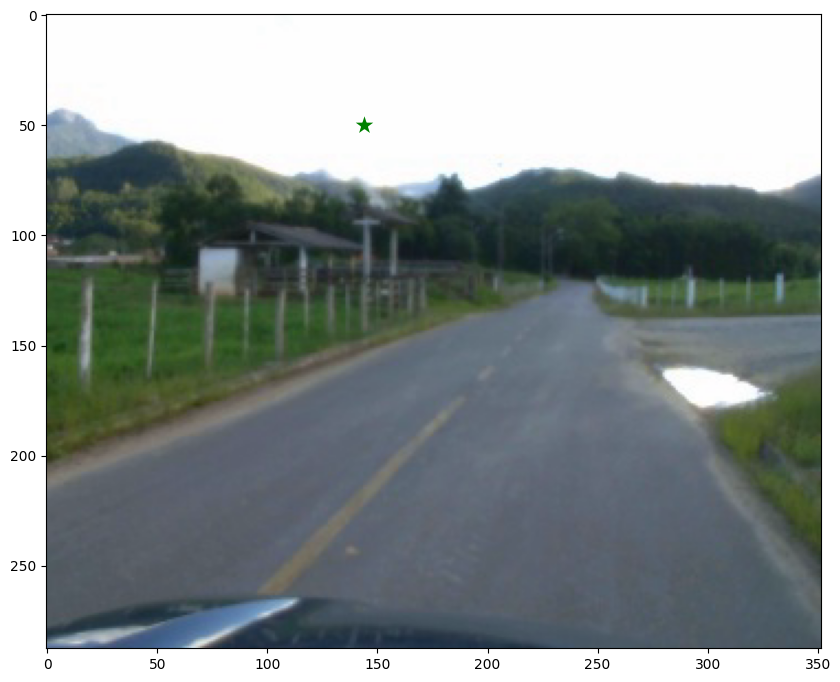

In [11]:
plt.figure(figsize=(10, 10))
plt.imshow(img_rgb)
show_points(input_point, input_label, plt.gca(), marker_size=300)
plt.axis('on')
plt.show()

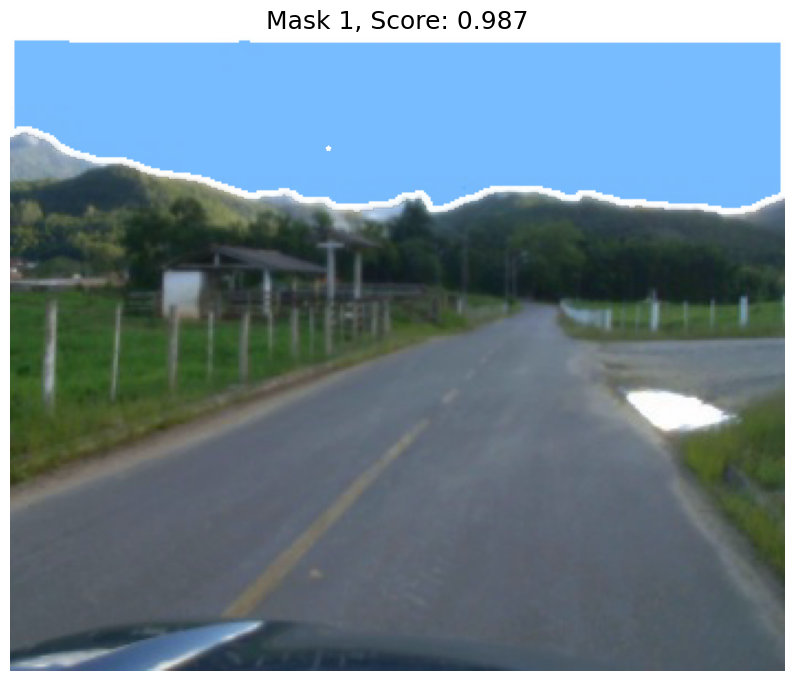

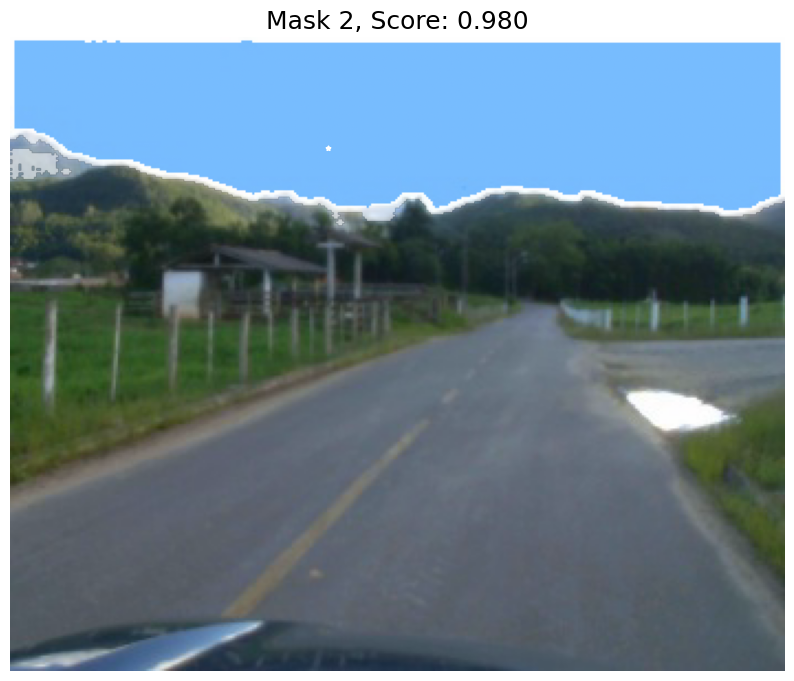

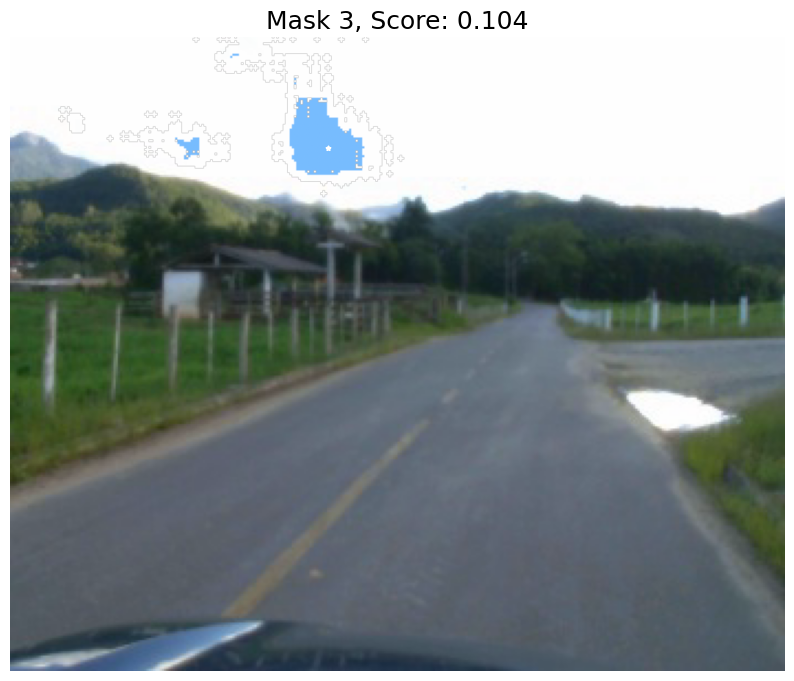

In [12]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)
sorted_ind = np.argsort(scores)[::-1]
masks = masks[sorted_ind]
scores = scores[sorted_ind]
logits = logits[sorted_ind]

show_masks(img_rgb, masks, scores, point_coords=input_point, input_labels=input_label, borders=True, marker_size=10)

In [13]:
from ipywidgets import interact, IntSlider, Checkbox
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio

class MaskInteractor:
    def __init__(self, predictor, image, multimask_output=True):
        self.predictor = predictor
        self.image = image
        self.multimask_output = multimask_output
        self.last_mask = None

    def show(self, x, y, multimask_output=False):
        input_point = np.array([[x, y]])
        input_label = np.array([1])

        self.multimask_output = multimask_output
        
        masks, scores, _ = self.predictor.predict(
            point_coords=input_point,
            point_labels=input_label,
            multimask_output=self.multimask_output,
        )
        sorted_ind = np.argsort(scores)[::-1]
        masks = masks[sorted_ind]
        scores = scores[sorted_ind]
        
        self.last_mask = masks[0]
        
        show_masks(self.image, masks, scores, point_coords=input_point, input_labels=input_label, borders=True, marker_size=300)

    def save_mask(self, path="mask.png"):
        if self.last_mask is not None:
            imageio.imwrite(path, (self.last_mask * 255).astype(np.uint8))
            print(f"Máscara salva em: {path}")
        else:
            print("Nenhuma máscara gerada ainda.")

    def plot_last_mask(self, cmap='gray'):
        plt.figure()
        print(np.unique(self.last_mask))
        plt.imshow((self.last_mask).astype(np.uint8), cmap=cmap)

def show_point_and_mask_interactive(predictor, image, multimask_output=False):
    height, width = image.shape[:2]
    interactor = MaskInteractor(predictor, image, multimask_output)
    interact(interactor.show,
             x=IntSlider(min=0, max=width-1, value=width//2, description='X'),
             y=IntSlider(min=0, max=height-1, value=height//2, description='Y'),
             multimask_output=Checkbox(
                 value=multimask_output,
                 description='Multi-máscara',
                 indent=False
             ))
    return interactor

# Uso:
multimask_output = False
mask_interactor = show_point_and_mask_interactive(predictor, img_rgb, multimask_output)


interactive(children=(IntSlider(value=176, description='X', max=351), IntSlider(value=144, description='Y', ma…

Máscara salva em: saida_mascara.png
[0. 1.]


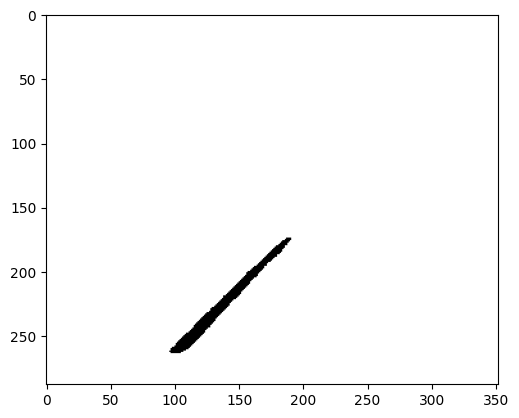

In [14]:
mask_interactor.save_mask("saida_mascara.png")
mask_interactor.plot_last_mask(cmap='binary')

### Metricas

In [17]:
class SegmentationMetrics:
    def __init__(self):
        self.reset()

    def reset(self):
        self.dice = 0.0
        self.jaccard = 0.0
        self.precision = 0.0
        self.recall = 0.0
        self.count = 0

    def update(self, pred, target):
        pred_bin = (pred > 0.5).float()
        target = target.float()

        inter = (pred_bin * target).sum()
        union = pred_bin.sum() + target.sum()

        dice = (2. * inter + 1e-5) / (union + 1e-5)
        jaccard = (inter + 1e-5) / ((pred_bin + target - pred_bin * target).sum() + 1e-5)
        precision = (inter + 1e-5) / (pred_bin.sum() + 1e-5)
        recall = (inter + 1e-5) / (target.sum() + 1e-5)

        self.dice += dice.item()
        self.jaccard += jaccard.item()
        self.precision += precision.item()
        self.recall += recall.item()
        self.count += 1

    def compute(self):
        if self.count == 0:
            return dict(dice=0, jaccard=0, precision=0, recall=0)
        return {
            "dice": self.dice / self.count,
            "jaccard": self.jaccard / self.count,
            "precision": self.precision / self.count,
            "recall": self.recall / self.count,
        }


### Trainer e Treinamento

In [18]:
import torch
import torch.nn.functional as F
import os
import json
from torch.amp import autocast, GradScaler
from contextlib import nullcontext
from tqdm import tqdm

class SAM2Trainer:
    def __init__(
        self,
        predictor,
        device,
        optimizer,
        scaler=None,
        use_amp=True,
        checkpoint_dir="./checkpoints",
        checkpoint_interval=5,
        total_steps=None,
        lr_max=1e-3,
        overfit_delta=0.0,
    ):
        self.predictor = predictor
        self.model = predictor.model
        self.device = device
        self.optimizer = optimizer
        self.scaler = scaler if use_amp else None
        self.use_amp = use_amp
        self.checkpoint_dir = checkpoint_dir
        self.checkpoint_interval = checkpoint_interval
        os.makedirs(self.checkpoint_dir, exist_ok=True)
        self.model.to(self.device)
        self.model.train()
        self.scheduler = None
        self.total_iter = 0
        if total_steps is not None:
            self.scheduler = torch.optim.lr_scheduler.OneCycleLR(
                optimizer,
                max_lr=lr_max,
                total_steps=total_steps,
                pct_start=0.15,
                anneal_strategy='cos',
                div_factor=25,
                final_div_factor=1e4,
            )
        self.best_dice = 0
        self.best_val_loss = float("inf")
        self.saved_before_overfit = False
        self.overfit_delta = overfit_delta

    def _save_model(self, epoch, metrics=None, filename=None):
        if filename is None:
            filename = f"sam2_epoch_{epoch:03d}.pth"
        path = os.path.join(self.checkpoint_dir, filename)
        torch.save({
            "epoch": epoch,
            "model_state_dict": self.model.state_dict(),
            "optimizer_state_dict": self.optimizer.state_dict(),
            "scaler_state_dict": self.scaler.state_dict() if self.scaler else None,
            "metrics": metrics,
        }, path)
        print(f"Checkpoint salvo: {path}")

    def _sam_loss(self, prd_logits, gt_masks_tensor):
        bce_loss = F.binary_cross_entropy_with_logits(prd_logits, gt_masks_tensor)
        prd_probs = torch.sigmoid(prd_logits)
        inter = (prd_probs * gt_masks_tensor).sum(dim=(1, 2))
        union = prd_probs.sum(dim=(1, 2)) + gt_masks_tensor.sum(dim=(1, 2)) - inter
        iou_loss = 1 - (inter + 1.0) / (union + 1.0)
        iou_loss = iou_loss.mean()
        total_loss = bce_loss + 0.1 * iou_loss
        return total_loss

    def _resize_pred(self, pred_mask, target_shape):
        if pred_mask.shape != target_shape:
            pred_mask = F.interpolate(
                pred_mask.unsqueeze(0).unsqueeze(0),
                size=target_shape, mode='bilinear', align_corners=False
            ).squeeze(0).squeeze(0)
        return pred_mask

    def _train_epoch(self, dataloader, log_every=20):
        self.model.train()
        running_loss = 0.0
        metrics = SegmentationMetrics()
        loop = tqdm(dataloader, total=len(dataloader), desc="TrainSAM2-OPT")
        iter_per_epoch = len(loop)
        for i, (images, masks, points, labels, num_objs) in enumerate(loop):
            images = images.to(self.device, non_blocking=True)
            masks = masks.to(self.device, non_blocking=True)
            points = points.to(self.device, non_blocking=True)
            labels = labels.to(self.device, non_blocking=True)
            num_objs = num_objs.to(self.device)
            batch_size = images.shape[0]

            for b in range(batch_size):
                image = images[b]
                gt_masks = masks[b][:num_objs[b]]
                input_point = points[b][:num_objs[b]]
                input_label = labels[b][:num_objs[b]]

                if hasattr(self.predictor, "set_image"):
                    try:
                        self.predictor.set_image(image.permute(1,2,0))
                    except Exception:
                        self.predictor.set_image(image.permute(1,2,0).cpu().numpy())

                if len(gt_masks) == 0:
                    continue

                self.optimizer.zero_grad()
                with autocast("cuda", dtype=torch.bfloat16) if self.use_amp else nullcontext():
                    mask_input, unnorm_coords, label_tensor, _ = self.predictor._prep_prompts(
                        input_point.cpu().numpy(),
                        input_label.cpu().numpy(),
                        box=None,
                        mask_logits=None,
                        normalize_coords=True
                    )
                    sparse_embeddings, dense_embeddings = self.model.sam_prompt_encoder(
                        points=(unnorm_coords, label_tensor), boxes=None, masks=None
                    )
                    batched_mode = unnorm_coords.shape[0] > 1
                    high_res_feats = [f[-1].unsqueeze(0) for f in self.predictor._features["high_res_feats"]]
                    low_res_masks, prd_scores, _, _ = self.model.sam_mask_decoder(
                        image_embeddings=self.predictor._features["image_embed"][-1].unsqueeze(0),
                        image_pe=self.model.sam_prompt_encoder.get_dense_pe(),
                        sparse_prompt_embeddings=sparse_embeddings,
                        dense_prompt_embeddings=dense_embeddings,
                        multimask_output=True,
                        repeat_image=batched_mode,
                        high_res_features=high_res_feats,
                    )

                    prd_logits = low_res_masks[:, 0]
                    gt_masks_tensor = gt_masks.float().to(self.device)
                    prd_logits = prd_logits.to(gt_masks_tensor.device)
                    prd_scores = prd_scores.to(gt_masks_tensor.device)
                    if prd_logits.shape != gt_masks_tensor.shape:
                        prd_logits = F.interpolate(
                            prd_logits.unsqueeze(0), size=gt_masks_tensor.shape[-2:], mode='bilinear', align_corners=False
                        ).squeeze(0)
                    total_loss = self._sam_loss(prd_logits, gt_masks_tensor)
                    prd_probs = torch.sigmoid(prd_logits)

                if self.scaler:
                    self.scaler.scale(total_loss).backward()
                    self.scaler.step(self.optimizer)
                    self.scaler.update()
                else:
                    total_loss.backward()
                    self.optimizer.step()
                running_loss += total_loss.item()

                for k in range(gt_masks_tensor.shape[0]):
                    pred_mask = prd_probs[k]
                    gt_mask = gt_masks_tensor[k]
                    pred_mask = self._resize_pred(pred_mask, gt_mask.shape)
                    metrics.update(pred_mask, gt_mask)

            if self.scheduler:
                self.scheduler.step()

            if i % log_every == 0:
                loop.set_postfix(loss=running_loss / ((i + 1)*batch_size), **metrics.compute())

        avg_loss = running_loss / (len(dataloader)*batch_size)
        return avg_loss, metrics.compute(), iter_per_epoch

    def evaluate(self, dataloader):
        self.model.eval()
        metrics = SegmentationMetrics()
        running_loss = 0.0
        total_samples = 0
        with torch.no_grad():
            for images, masks, points, labels, num_objs in tqdm(dataloader, desc="EvalSAM2"):
                images = images.to(self.device, non_blocking=True)
                masks = masks.to(self.device, non_blocking=True)
                points = points.to(self.device, non_blocking=True)
                labels = labels.to(self.device, non_blocking=True)
                num_objs = num_objs.to(self.device)
                batch_size = images.shape[0]
                for b in range(batch_size):
                    image = images[b]
                    gt_masks = masks[b][:num_objs[b]]
                    input_point = points[b][:num_objs[b]]
                    input_label = labels[b][:num_objs[b]]
                    if hasattr(self.predictor, "set_image"):
                        try:
                            self.predictor.set_image(image.permute(1,2,0))
                        except Exception:
                            self.predictor.set_image(image.permute(1,2,0).cpu().numpy())
                    if len(gt_masks) == 0:
                        continue
                    with autocast("cuda", dtype=torch.bfloat16) if self.use_amp else nullcontext():
                        mask_input, unnorm_coords, label_tensor, _ = self.predictor._prep_prompts(
                            input_point.cpu().numpy(),
                            input_label.cpu().numpy(),
                            box=None,
                            mask_logits=None,
                            normalize_coords=True
                        )
                        sparse_embeddings, dense_embeddings = self.model.sam_prompt_encoder(
                            points=(unnorm_coords, label_tensor), boxes=None, masks=None
                        )
                        batched_mode = unnorm_coords.shape[0] > 1
                        high_res_feats = [f[-1].unsqueeze(0) for f in self.predictor._features["high_res_feats"]]
                        low_res_masks, prd_scores, _, _ = self.model.sam_mask_decoder(
                            image_embeddings=self.predictor._features["image_embed"][-1].unsqueeze(0),
                            image_pe=self.model.sam_prompt_encoder.get_dense_pe(),
                            sparse_prompt_embeddings=sparse_embeddings,
                            dense_prompt_embeddings=dense_embeddings,
                            multimask_output=True,
                            repeat_image=batched_mode,
                            high_res_features=high_res_feats,
                        )
                        prd_logits = low_res_masks[:, 0]
                        gt_masks_tensor = gt_masks.float().to(self.device)
                        prd_logits = prd_logits.to(gt_masks_tensor.device)
                        if prd_logits.shape != gt_masks_tensor.shape:
                            prd_logits = F.interpolate(
                                prd_logits.unsqueeze(0), size=gt_masks_tensor.shape[-2:], mode='bilinear', align_corners=False
                            ).squeeze(0)
                        prd_probs = torch.sigmoid(prd_logits)
                        val_loss = self._sam_loss(prd_logits, gt_masks_tensor)
                        running_loss += val_loss.item()
                        total_samples += 1

                        for k in range(gt_masks_tensor.shape[0]):
                            pred_mask = prd_probs[k]
                            gt_mask = gt_masks_tensor[k]
                            pred_mask = self._resize_pred(pred_mask, gt_mask.shape)
                            metrics.update(pred_mask, gt_mask)
        avg_loss = running_loss / (total_samples if total_samples > 0 else 1)
        return avg_loss, metrics.compute()

    def save_best_loss_model(self, epoch, metrics=None):
        self._save_model(epoch, metrics=metrics, filename="best_model_val_loss.pth")

    def save_best_model_before_overfit(self, epoch, metrics=None):
        self._save_model(epoch, metrics=metrics, filename="best_model_before_overfit.pth")

    def fit(self, train_loader, val_loader, num_epochs):
        history = {
            "train_loss": [],
            "val_loss": [],
            "train_metrics": [],
            "val_metrics": [],
            "lr": [],
            "iter_per_epoch": [],
        }
        for epoch in range(1, num_epochs + 1):
            print(f"\nEpoch {epoch}/{num_epochs}")
            lr = self.optimizer.param_groups[0]["lr"]
            train_loss, train_metrics, iter_per_epoch = self._train_epoch(train_loader)
            self.total_iter += iter_per_epoch
            val_loss, val_metrics = self.evaluate(val_loader)
            history["train_loss"].append(train_loss)
            history["val_loss"].append(val_loss)
            history["train_metrics"].append(train_metrics)
            history["val_metrics"].append(val_metrics)
            history["lr"].append(lr)
            history["iter_per_epoch"].append(self.total_iter)

            print(f"Epoch {epoch} Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Train Dice: {train_metrics['dice']:.4f} | Val Dice: {val_metrics['dice']:.4f} | LR: {lr:.6f} | Iter: {iter_per_epoch}")

            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                self.save_best_loss_model(epoch, metrics=val_metrics)

            if (not self.saved_before_overfit) and (val_loss > train_loss + self.overfit_delta):
                self.save_best_model_before_overfit(epoch, metrics=val_metrics)
                self.saved_before_overfit = True

            if self.checkpoint_interval and (epoch % self.checkpoint_interval == 0):
                self._save_model(epoch, metrics=val_metrics)

            if val_metrics["dice"] > self.best_dice:
                self.best_dice = val_metrics["dice"]
                self._save_model(epoch, metrics=val_metrics)

        return history

    def save_history(self, history, filename="sam2_training_history.json"):
        with open(filename, "w") as f:
            json.dump(history, f, indent=2)
        print(f"Histórico salvo em {filename}")


In [18]:
optimizer = torch.optim.AdamW(predictor.model.parameters(), lr=1e-5, weight_decay=4e-5)
scaler = torch.amp.GradScaler()
NUM_EPOCHS = 20
total_steps = len(train_loader) * NUM_EPOCHS
trainer = SAM2Trainer(
    predictor=predictor,
    device=device,
    optimizer=optimizer,
    scaler=scaler,
    use_amp=True,
    checkpoint_dir="./checkpoints_sam2",
    checkpoint_interval=5,
    total_steps=total_steps,
    lr_max=1e-3,
)

history = trainer.fit(train_loader, val_loader, num_epochs=NUM_EPOCHS)
trainer.save_history(history)


Epoch 1/20


EvalSAM2: 100%|██████████| 4/4 [00:02<00:00,  1.44it/s]


Epoch 1 Loss: 0.4780 | Val Loss: 0.3878 | Train Dice: 0.2372 | Val Dice: 0.2415 | LR: 0.000040 | Iter: 17
Checkpoint salvo: ./checkpoints_sam2/best_model_val_loss.pth
Checkpoint salvo: ./checkpoints_sam2/sam2_epoch_001.pth

Epoch 2/20


EvalSAM2: 100%|██████████| 4/4 [00:02<00:00,  1.37it/s]


Epoch 2 Loss: 0.2681 | Val Loss: 0.1913 | Train Dice: 0.3261 | Val Dice: 0.4014 | LR: 0.000289 | Iter: 17
Checkpoint salvo: ./checkpoints_sam2/best_model_val_loss.pth
Checkpoint salvo: ./checkpoints_sam2/sam2_epoch_002.pth

Epoch 3/20


EvalSAM2: 100%|██████████| 4/4 [00:02<00:00,  1.38it/s]


Epoch 3 Loss: 0.1706 | Val Loss: 0.1755 | Train Dice: 0.4169 | Val Dice: 0.4358 | LR: 0.000777 | Iter: 17
Checkpoint salvo: ./checkpoints_sam2/best_model_val_loss.pth
Checkpoint salvo: ./checkpoints_sam2/best_model_before_overfit.pth
Checkpoint salvo: ./checkpoints_sam2/sam2_epoch_003.pth

Epoch 4/20


EvalSAM2: 100%|██████████| 4/4 [00:02<00:00,  1.39it/s]


Epoch 4 Loss: 0.1474 | Val Loss: 0.1250 | Train Dice: 0.4566 | Val Dice: 0.4672 | LR: 0.001000 | Iter: 17
Checkpoint salvo: ./checkpoints_sam2/best_model_val_loss.pth
Checkpoint salvo: ./checkpoints_sam2/sam2_epoch_004.pth

Epoch 5/20


EvalSAM2: 100%|██████████| 4/4 [00:02<00:00,  1.44it/s]


Epoch 5 Loss: 0.1286 | Val Loss: 0.1200 | Train Dice: 0.4722 | Val Dice: 0.5188 | LR: 0.000990 | Iter: 17
Checkpoint salvo: ./checkpoints_sam2/best_model_val_loss.pth
Checkpoint salvo: ./checkpoints_sam2/sam2_epoch_005.pth
Checkpoint salvo: ./checkpoints_sam2/sam2_epoch_005.pth

Epoch 6/20


EvalSAM2: 100%|██████████| 4/4 [00:02<00:00,  1.36it/s]


Epoch 6 Loss: 0.1246 | Val Loss: 0.1277 | Train Dice: 0.4929 | Val Dice: 0.5198 | LR: 0.000964 | Iter: 17
Checkpoint salvo: ./checkpoints_sam2/sam2_epoch_006.pth

Epoch 7/20


EvalSAM2: 100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


Epoch 7 Loss: 0.1208 | Val Loss: 0.1093 | Train Dice: 0.5115 | Val Dice: 0.5386 | LR: 0.000922 | Iter: 17
Checkpoint salvo: ./checkpoints_sam2/best_model_val_loss.pth
Checkpoint salvo: ./checkpoints_sam2/sam2_epoch_007.pth

Epoch 8/20


EvalSAM2: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s]


Epoch 8 Loss: 0.1201 | Val Loss: 0.1222 | Train Dice: 0.5202 | Val Dice: 0.5449 | LR: 0.000866 | Iter: 17
Checkpoint salvo: ./checkpoints_sam2/sam2_epoch_008.pth

Epoch 9/20


EvalSAM2: 100%|██████████| 4/4 [00:02<00:00,  1.36it/s]


Epoch 9 Loss: 0.1147 | Val Loss: 0.1162 | Train Dice: 0.5264 | Val Dice: 0.5431 | LR: 0.000797 | Iter: 17

Epoch 10/20


EvalSAM2: 100%|██████████| 4/4 [00:02<00:00,  1.36it/s]


Epoch 10 Loss: 0.1137 | Val Loss: 0.1056 | Train Dice: 0.5259 | Val Dice: 0.5473 | LR: 0.000718 | Iter: 17
Checkpoint salvo: ./checkpoints_sam2/best_model_val_loss.pth
Checkpoint salvo: ./checkpoints_sam2/sam2_epoch_010.pth
Checkpoint salvo: ./checkpoints_sam2/sam2_epoch_010.pth

Epoch 11/20


EvalSAM2: 100%|██████████| 4/4 [00:02<00:00,  1.37it/s]


Epoch 11 Loss: 0.1095 | Val Loss: 0.1108 | Train Dice: 0.5366 | Val Dice: 0.5471 | LR: 0.000632 | Iter: 17

Epoch 12/20


EvalSAM2: 100%|██████████| 4/4 [00:02<00:00,  1.41it/s]


Epoch 12 Loss: 0.1149 | Val Loss: 0.1019 | Train Dice: 0.5403 | Val Dice: 0.5439 | LR: 0.000541 | Iter: 17
Checkpoint salvo: ./checkpoints_sam2/best_model_val_loss.pth

Epoch 13/20


EvalSAM2: 100%|██████████| 4/4 [00:02<00:00,  1.45it/s]


Epoch 13 Loss: 0.1095 | Val Loss: 0.1068 | Train Dice: 0.5356 | Val Dice: 0.5418 | LR: 0.000448 | Iter: 17

Epoch 14/20


EvalSAM2: 100%|██████████| 4/4 [00:04<00:00,  1.16s/it]


Epoch 14 Loss: 0.1084 | Val Loss: 0.1022 | Train Dice: 0.5352 | Val Dice: 0.5423 | LR: 0.000358 | Iter: 17

Epoch 15/20


EvalSAM2: 100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


Epoch 15 Loss: 0.1053 | Val Loss: 0.1081 | Train Dice: 0.5400 | Val Dice: 0.5337 | LR: 0.000272 | Iter: 17
Checkpoint salvo: ./checkpoints_sam2/sam2_epoch_015.pth

Epoch 16/20


EvalSAM2: 100%|██████████| 4/4 [00:02<00:00,  1.40it/s]


Epoch 16 Loss: 0.1119 | Val Loss: 0.1031 | Train Dice: 0.5356 | Val Dice: 0.5538 | LR: 0.000194 | Iter: 17
Checkpoint salvo: ./checkpoints_sam2/sam2_epoch_016.pth

Epoch 17/20


EvalSAM2: 100%|██████████| 4/4 [00:02<00:00,  1.42it/s]


Epoch 17 Loss: 0.1097 | Val Loss: 0.1021 | Train Dice: 0.5343 | Val Dice: 0.5382 | LR: 0.000127 | Iter: 17

Epoch 18/20


EvalSAM2: 100%|██████████| 4/4 [00:02<00:00,  1.41it/s]


Epoch 18 Loss: 0.1039 | Val Loss: 0.1075 | Train Dice: 0.5456 | Val Dice: 0.5453 | LR: 0.000072 | Iter: 17

Epoch 19/20


EvalSAM2: 100%|██████████| 4/4 [00:03<00:00,  1.28it/s]


Epoch 19 Loss: 0.1059 | Val Loss: 0.1103 | Train Dice: 0.5447 | Val Dice: 0.5500 | LR: 0.000032 | Iter: 17

Epoch 20/20


EvalSAM2: 100%|██████████| 4/4 [00:02<00:00,  1.43it/s]


Epoch 20 Loss: 0.1032 | Val Loss: 0.1041 | Train Dice: 0.5444 | Val Dice: 0.5434 | LR: 0.000008 | Iter: 17
Checkpoint salvo: ./checkpoints_sam2/sam2_epoch_020.pth
Histórico salvo em sam2_training_history.json


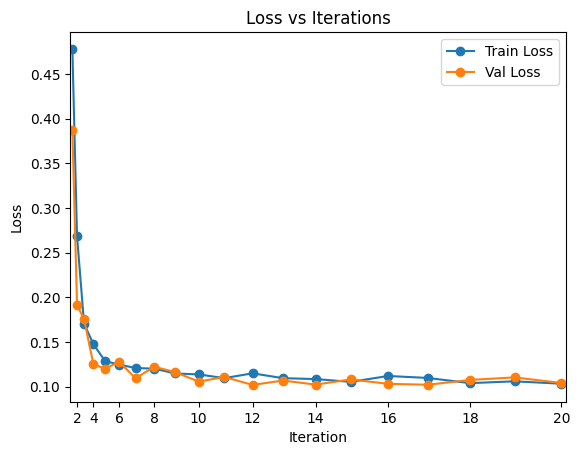

In [31]:
import matplotlib.pyplot as plt
import numpy as np

def plot_loss(history: dict, iter_ratio: int = 2, ax=None):
    train_losses = history["train_loss"]
    val_losses   = history["val_loss"]
    ipe = history["iter_per_epoch"]

    ipe = np.array(ipe, dtype=np.float32)
    iter_points = np.cumsum(ipe)
    epochs = np.arange(1, len(train_losses) + 1)

    mask = (epochs % iter_ratio == 0)
    mask[-1] = True

    ticks = iter_points[mask]
    labels = epochs[mask]

    if ax is None:
        fig, ax = plt.subplots()

    ax.plot(iter_points, train_losses, marker='o', label='Train Loss')
    ax.plot(iter_points, val_losses, marker='o', label='Val Loss')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Loss')
    ax.set_title(f'Loss vs Iterations')
    ax.set_xlim(0, iter_points[-1] + ipe[-1] * 0.1)
    ax.set_xticks(ticks, labels)
    ax.legend()
    ax.grid(False)

    if ax is None:
        plt.tight_layout()
        plt.show()


def plot_lr(history: dict, ax=None):
    if ax is None:
        fig, ax = plt.subplots()

    ax.plot(history["lr"], label="Learning Rate")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Learning Rate")
    ax.set_title("Learning Rate Schedule")
    ax.legend()
    ax.grid(False)
    if ax is None:
        plt.tight_layout()
        plt.show()

plot_loss(history, iter_ratio=2)

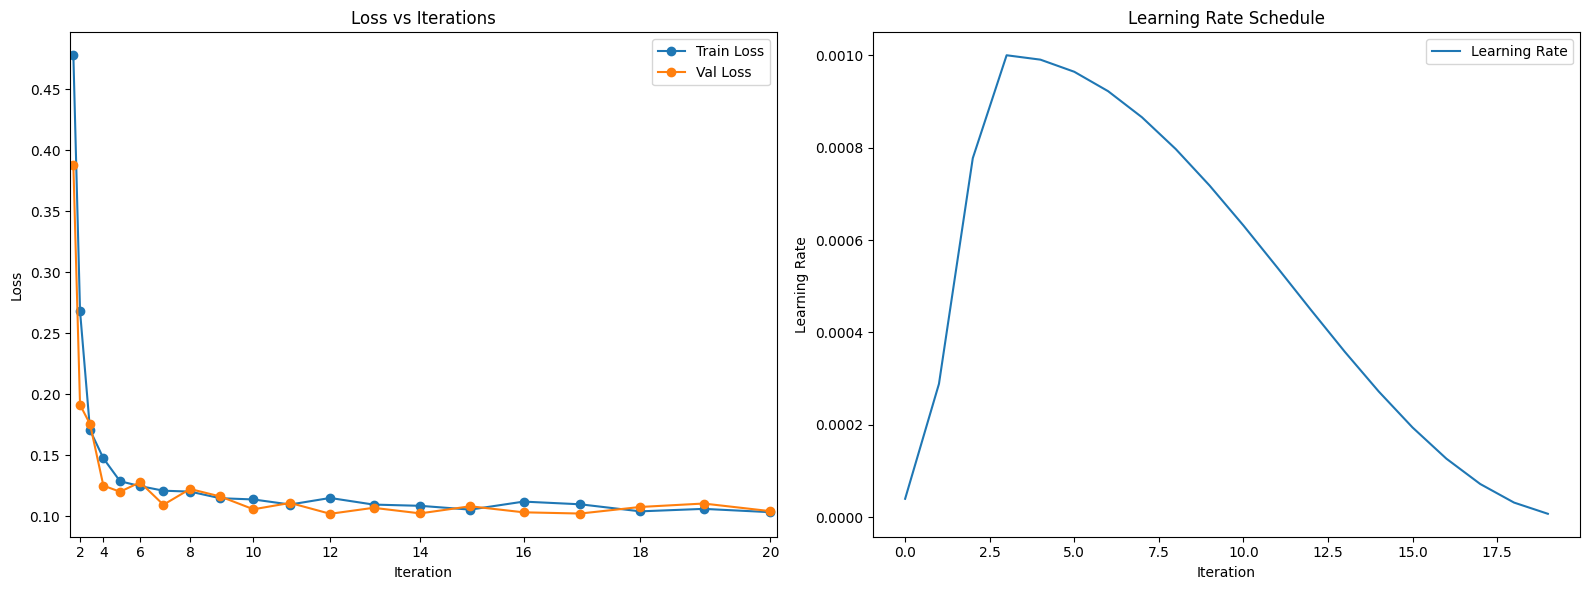

In [32]:
def plot_result(history: dict, iter_ratio: int = 2):
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))
    plot_loss(history, iter_ratio, ax=axs[0])
    plot_lr(history, ax=axs[1])
    plt.tight_layout()
    plt.show()

plot_result(history, iter_ratio=2)

In [25]:
history.keys()

dict_keys(['train_loss', 'val_loss', 'train_metrics', 'val_metrics', 'lr', 'iter_per_epoch'])

In [30]:
print(history['val_metrics'][0].keys())
print(history['train_metrics'][0].keys())

dict_keys(['dice', 'jaccard', 'precision', 'recall'])
dict_keys(['dice', 'jaccard', 'precision', 'recall'])


In [35]:
import pandas as pd

def get_metrics_table_from_history(history: dict) -> pd.DataFrame:
    num_epochs = len(history['train_loss'])
    data = []

    for epoch in range(num_epochs):
        row = {
            "epoch": epoch + 1,
            "train_loss": history["train_loss"][epoch],
            "val_loss": history["val_loss"][epoch],
        }

        for k, v in history["train_metrics"][epoch].items():
            row[f"train_{k}"] = v

        for k, v in history["val_metrics"][epoch].items():
            row[f"val_{k}"] = v

        data.append(row)

    return pd.DataFrame(data)

df_metrics = get_metrics_table_from_history(history)
display(df_metrics.head())



,epoch,train_loss,val_loss,train_dice,train_jaccard,train_precision,train_recall,val_dice,val_jaccard,val_precision,val_recall
0,1,0.477982,0.387773,0.237168,0.192871,0.259179,0.755136,0.241518,0.188086,0.328971,0.592491
1,2,0.268133,0.191279,0.326058,0.265213,0.377461,0.683710,0.401402,0.327412,0.417409,0.749570
2,3,0.170568,0.175467,0.416886,0.341102,0.462054,0.675658,0.435778,0.363023,0.430554,0.790659
3,4,0.147403,0.125022,0.456614,0.373932,0.541256,0.620318,0.467200,0.387508,0.510810,0.696966
4,5,0.128609,0.119995,0.472244,0.387010,0.558692,0.614051,0.518849,0.428225,0.546659,0.735244


![banner cnns ppgcc ufsc](https://lapix.ufsc.br/wp-content/uploads/2022/10/rodape-CC.png)